# Getting Started with Images

In this notebook, we'll look at some fundamental techniques for working with images and image files. Along the way, you'll become familar with the images that you'll be using throughout this course, which are adapted from the PASCAL Visual Object Classes Challenge (VOC2007) dataset at http://host.robots.ox.ac.uk/pascal/VOC/voc2007/.

Let's start by visualizing some of these images. They're stored in a folder hierarchy that contains a subfolder for each type of object shown in the image; so we'll display the first image in each folder.



In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


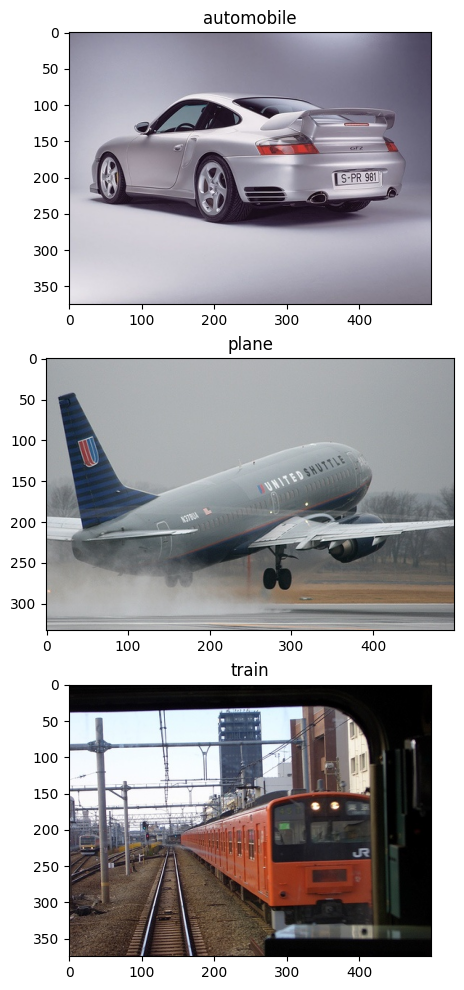

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mp_image

# Required magic to display matplotlib plots in notebooks
%matplotlib inline

src_folder = "data/voc"

# Set up a figure of an appropriate size
fig = plt.figure(figsize=(12, 12))

# loop through the subfolders
for root, folders, filenames in os.walk(src_folder):
    image_num = 0
    num_folders = len(folders)
    for folder in sorted(folders):
        # Keep an incrementing count of each image
        image_num +=1
        # Find the first image file in the folder
        file_name = os.listdir(os.path.join(root,folder))[1]
        # Get the full path from the root folder
        file_path = os.path.join(root,folder, file_name)
        # Open the file using the matplotlib.image library
        image = mp_image.imread(file_path)
        # Add the image to the figure (which will have a row for each folder, each containing one column for the image)
        a=fig.add_subplot(num_folders, 1, image_num)
        # Add the image to the plot
        image_plot = plt.imshow(image)
        # Add a caption with the folder name
        a.set_title(folder)

# Show the plot
plt.show()

A few things you should note about this code:
1. It's common in computer vision scenarios to have images organized in folders based on their subject, or *class*. You should familiarize yourself with the [**os**](https://docs.python.org/3.6/library/os.html) library in Python, which provides lots of ways for you to work with the file system.
2. The [**Matplotlib**](https://matplotlib.org/index.html) library provides lots of ways to display plots and images. Note in particular that if you need to display multiple images, you can create a subplot for each image, The syntax for creating a subplot can be confusing; for each subplot you need to specify:
    - The total number of *rows* in the grid of subplots to be displayed (this value must be the same for each subplot)
    - The total number of *columns* in the grid of subplots to be displayed (again, this must be the same for each subplot)
    - The ordinal position of "this" subplot in the grid (the first subplot should be numbered 1, the second 2, and so on)
3. In addition to the Matplotlib library, there are other common libraries for working with images:
    - [**PIL**](https://pillow.readthedocs.io/en/stable/) (based on the **Pillow** fork)
    - [**OpenCV**](https://opencv.org/)
    - [**Scikit-Image**](https://scikit-image.org/)

Of these, PIL is already installed in the colab Notebooks environment, but we'll need to unstall the OpenCV library and upgrade SciKit-Image to the latest version using `pip`:

In [3]:
!pip install opencv-python
!pip install --upgrade scikit-image
!pip install pillow

Now let's use each of these libraries to load an image, and then use matplotlib to display them:

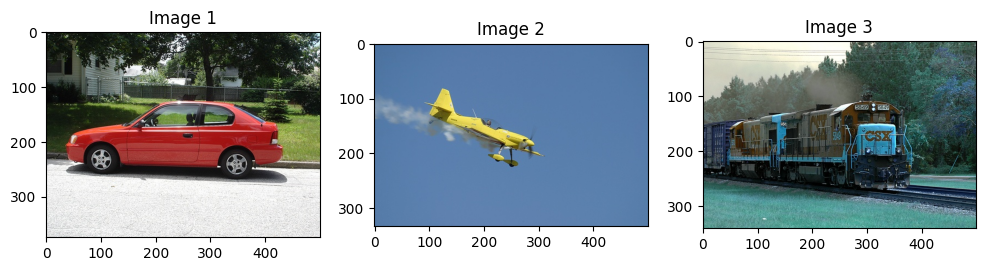

In [2]:
from PIL import Image
import skimage as sk
from skimage import io as sk_io
import cv2

images = []

pil_image = Image.open(os.path.join(src_folder, "automobile", "000522.jpg"))
images.append(pil_image)
sk_image = sk_io.imread(os.path.join(src_folder, "plane", "000228.jpg"))
images.append(sk_image)
cv_image = cv2.imread(os.path.join(src_folder, "train", "000712.jpg"))
images.append(cv_image)

# Set up a figure of an appropriate size
fig = plt.figure(figsize=(12, 12))

image_num = 0
num_images = len(images)
# loop through the images
for image_idx in range(num_images):
    # Keep an incrementing count of each image
    a=fig.add_subplot(1, num_images, image_idx+1)
    # Add the image to the plot
    image_plot = plt.imshow(images[image_idx])
    # Add a caption with the folder name
    a.set_title("Image " + str(image_idx+1))

# Show the plot
plt.show()

Note that this time we've added the subplots to create a single row with a column for each image.

Also, what's going on with Image 3? The colors look wrong.

It turns out that the OpenCV library loads images in a different default format from the others, so we need to do some conversion to get it to look right:

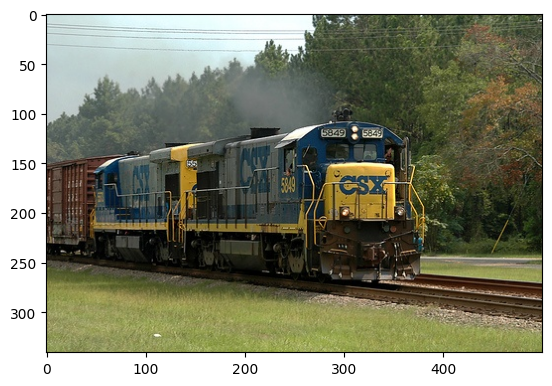

In [5]:
cv_image_rgb = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)

plt.imshow(cv_image_rgb)

That's better - so what happened?

Well, images are really just arrays of pixel values, and in the case of color images, they're made up of multiple dimensions , or *channels*. In a JPEG image, these channels usually represent the pixel intensities for red, green, and blue (RGB), but by default, OpenCV orders these as blue, green, red (BGR).

In Python, we typically handle arrays of numeric values using the [**Numpy**](https://docs.scipy.org/doc/numpy/) library.

Let's check the data type of the (now fixed) OpenCV image object:

In [6]:
type(cv_image_rgb)

numpy.ndarray

Aha! It's actually a Numpy multidimensional array. What about the scikit-image object?

In [7]:
type (sk_image)

numpy.ndarray

Thsi is also a Numpy array. So what about the PIL image object?

In [8]:
type (pil_image)

PIL.JpegImagePlugin.JpegImageFile

Hmm, this one's different - it looks like PIL objects have their own image-specific data type. However, all is not lost - it's easy to convert a PIL image to a Numpy array:

numpy.ndarray

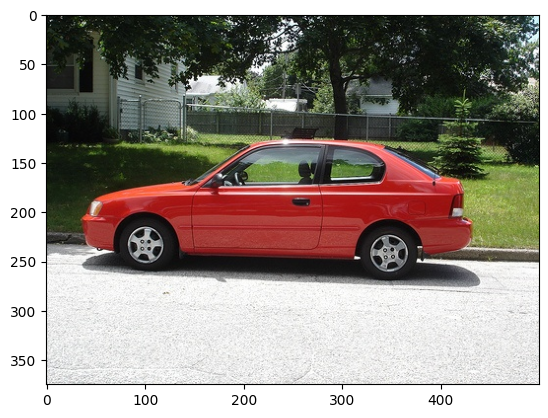

In [9]:
pil_array = np.array(pil_image)
plt.imshow(pil_array)
type(pil_array)

It's also easy to convert images in Numpy array format to PIL images:

PIL.Image.Image

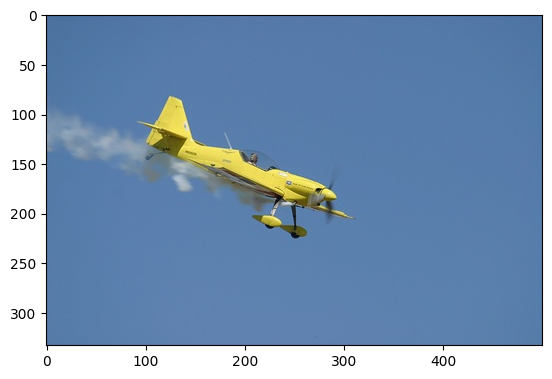

In [10]:
pil_sk_image = Image.fromarray(sk_image)
plt.imshow(pil_sk_image)
type(pil_sk_image)

While we're at it, let's check the shape of these Numpy array images:

In [11]:
sk_image.shape

(333, 500, 3)

This image is a 3-dimensional array (a dimension each for the red, green, and blue color channels); and the dimensions of the image are 333 pixels high by 500 pixels wide.

We can convert color images to grayscale, let's see what effect that has:

(333, 500)

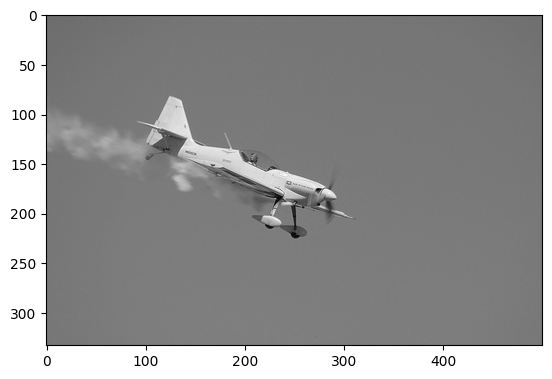

In [12]:
sk_gray_image = sk.color.rgb2gray(sk_image)
plt.imshow(sk_gray_image, 'gray')
sk_gray_image.shape

Noe the shape of the image includes only two dimensions - height and width.

Note also that the `plt.imshow` method requires a parameter to tell it that this image should be displayed in grayscale; otherwise it will try to show a single-channel image using three channels!

## Manipulating Images

So we've seen how to open and display images, and played around a little with type conversions and color channels. What else can we do with images?

How about changing their orientation by rotating them? PIL includes a `rotate` method that we can use:

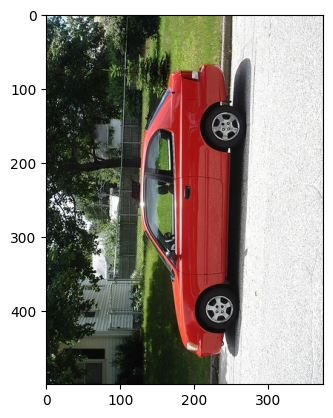

In [13]:
rotated_pil_image = pil_image.rotate(90, expand=1)
plt.imshow(rotated_pil_image)

The **expand** parameter tells PIL to change the image dimenions to fit the rotated orientation. Without this, we'd get an image with the original dimensions with a resized, rotated version of the image and the space that was created filled in, like this:

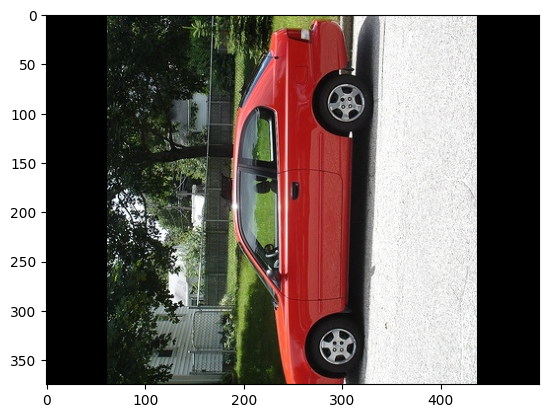

In [14]:
rotated_pil_image = pil_image.rotate(90)
plt.imshow(rotated_pil_image)

Its common for mulitple libraries to provide similar functionality - for example, Scikit-image has a library of transformations, including a **rotate** method that behaves similarly to PIL's:

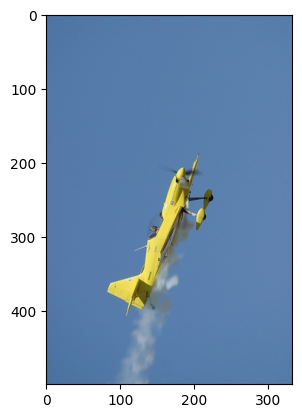

In [15]:
from skimage import transform as sk_transform
rotated_sk_image = sk_transform.rotate(sk_image, 90, resize=True)
plt.imshow(rotated_sk_image)

You can also flip images. One way to do this is to take advantage of the fact that an image is a Numpy array, and Numpy has a `flip` method:

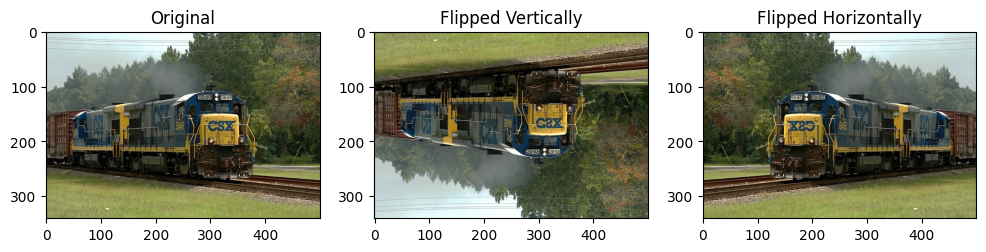

In [16]:
import numpy as np
upended_cv_image_rgb = np.flip(cv_image_rgb, axis=0)
mirrored_cv_image_rgb = np.flip(cv_image_rgb, axis=1)

fig = plt.figure(figsize=(12, 12))

# Plot original image
a=fig.add_subplot(1, 3, 1)
image_plot_1 = plt.imshow(cv_image_rgb)
a.set_title("Original")

# Plot upended image
a=fig.add_subplot(1, 3, 2)
image_plot_2 = plt.imshow(upended_cv_image_rgb)
a.set_title("Flipped Vertically")

# Plot mirrored image
a=fig.add_subplot(1, 3, 3)
image_plot_3 = plt.imshow(mirrored_cv_image_rgb)
a.set_title("Flipped Horizontally")

plt.show()

## Resizing Images
You may have noted that by default, Matplotlib plots images with an axis that shows the height and width of the image in pixels - the plots themselves are scaled to be displayed in the Notebook; but what if you actually want to resize an image?

One way is to use PIL's **thumbnail** method:

Original size: 500 x 375
New size: 150 x 113


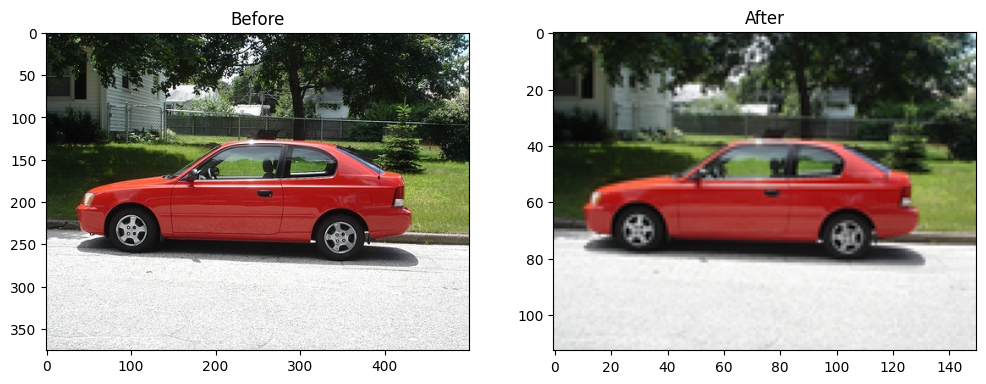

In [17]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
%matplotlib inline


# Get the PIL image size
o_h, o_w = pil_image.size
print('Original size:', o_h, 'x', o_w)

# We'll resize this so it's 150 pixels on its widest dimensions
target_size = (150,150)
resized_img = pil_image.copy()
resized_img.thumbnail(target_size, Image.Resampling.LANCZOS)
n_h, n_w = resized_img.size
print('New size:', n_h, 'x', n_w)

# Show the original and resized images
# Create a figure
fig = plt.figure(figsize=(12, 12))

# Subplot for original image
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(pil_image)
a.set_title('Before')

# Subplot for resized image
a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(resized_img)
a.set_title('After')

plt.show()


Note that what this actually did was to *rescale* the image, even through we specified 150 pixels as the target size for both height and width, the image was rescaled so that it's longest dimension (width) is set to 150 pixels, and the height is resized proportionally to keep the right aspect ratio.

What if we actually want to make both dimensions 150 pixels so we change the shape of the image? We can use the **resize** method:

Original size: 500 x 375
New size: 150 x 150


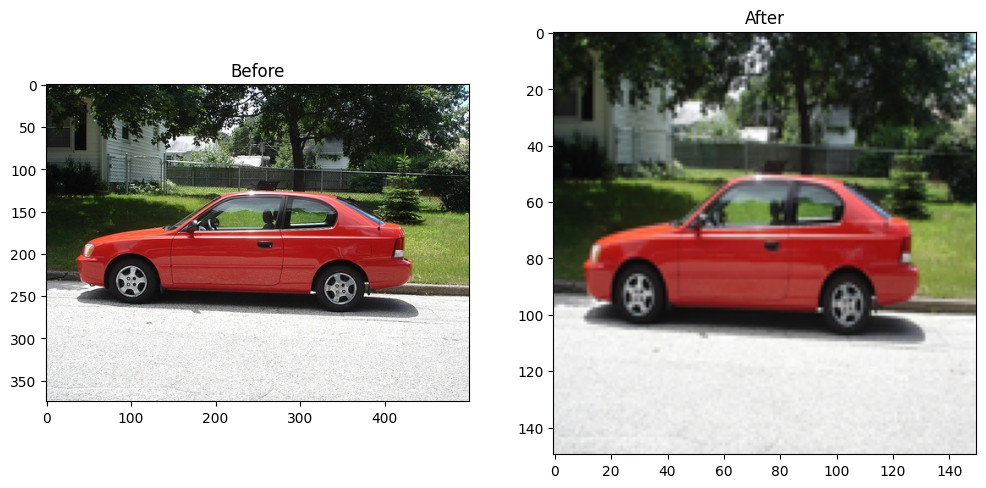

In [18]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
%matplotlib inline

# Get the image size
o_h, o_w = pil_image.size
print('Original size:', o_h, 'x', o_w)

# We'll resize this so it's 150 x 150
target_size = (150,150)
new_img = pil_image.resize(target_size)
n_h, n_w = new_img.size
print('New size:', n_h, 'x', n_w)

# Show the original and resized images
# Create a figure
fig = plt.figure(figsize=(12, 12))

# Subplot for original image
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(pil_image)
a.set_title('Before')

# Subplot for resized image
a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(new_img)
a.set_title('After')

plt.show()


Well, that worked; but notice that the image is not scaled. We resized the rectangular image to have square dimensions, and the image is skewed to fill the new size. If we want to resize the image and change its shape without distorting it, we'll need to *scale* the image so that its largest dimension fits our new desired size, and fill out any additional space with some sort of border.

To accomplish this, we'll use the **thumbnail** method to rescale the image so that it's longest dimension fits the desired size; and then we'll create a new "background" image of the right dimensions, and then *paste* the rescaled thumbnail into the middle of the background. Since there are a few steps to this, we'll encapsulate all of them in a function:

Original size: 500 x 375
New size: 150 x 150


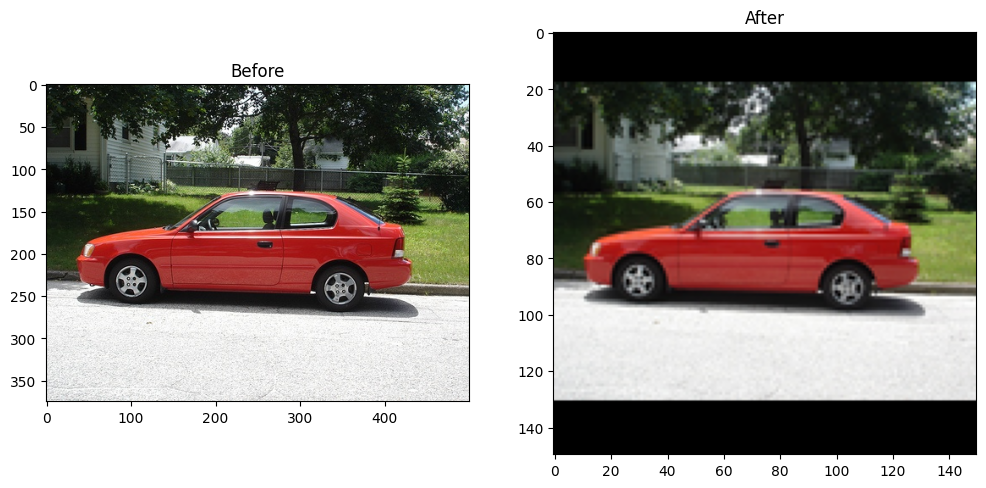

In [19]:
def resize_image(src_image, size=(200,200), bg_color="white"):
    from PIL import Image, ImageOps

    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.Resampling.LANCZOS)

    # Create a new square background image
    new_image = Image.new("RGB", size, bg_color)

    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))

    # return the resized image
    return new_image


# Get the image size
o_h, o_w = pil_image.size
print('Original size:', o_h, 'x', o_w)

# We'll resize this so it's 150 x 150 with black padding
target_size = (150,150)
pad_color = "black"
resized_img = resize_image(pil_image.copy(), target_size, pad_color)
n_h, n_w = resized_img.size
print('New size:', n_h, 'x', n_w)

# Show the original and resized images
# Create a figure
fig = plt.figure(figsize=(12, 12))

# Subplot for original image
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(pil_image)
a.set_title('Before')

# Subplot for resized image
a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(resized_img)
a.set_title('After')

plt.show()


This time the image keeps its aspect ratio, and the space is filled to make it fit into the new shape.

## Saving Images
Now that we've made a few changes top out images, let's look at saving them. First we'll create a folder for them, deleting it if it already exists:

In [20]:
import os, shutil

image_folder = "my_images"

# Delete the folder if it already exists
if os.path.exists(image_folder):
    shutil.rmtree(image_folder)

# Create the folder
os.makedirs(image_folder)
print("Ready to save images in", image_folder)

Ready to save images in my_images


To save a PIL image, use the **save** method of the PIL image object:

In [21]:
file_name = "resized_car.jpg"
file_path = os.path.join(image_folder, file_name)

# Save the image
resized_img.save(file_path, format="JPEG")
print("Image saved as", file_path)

Image saved as my_images/resized_car.jpg


The **io** namespace in the **Scikit-image** library has an **imsave** method:

In [22]:
file_name = "rotated_plane.jpg"
file_path = os.path.join(image_folder, file_name)
# Convert the image data to uint8 (8-bit unsigned integer)
rotated_sk_image_uint8 = (rotated_sk_image * 255).astype(np.uint8)

# Save the image
sk_io.imsave(fname=file_path, arr=rotated_sk_image_uint8)
print("Image saved as", file_path)


Image saved as my_images/rotated_plane.jpg


The OpenCV library has an **imwrite** method:

In [23]:
file_name = "flipped_train.jpg"
file_path = os.path.join(image_folder, file_name)

# Save the image
cv2.imwrite(filename=file_path, img=mirrored_cv_image_rgb)
print("Image saved as", file_path)

Image saved as my_images/flipped_train.jpg


The **matplotlib.pyplot** library has an **imsave** method:

In [24]:
file_name = "original_train.jpg"
file_path = os.path.join(image_folder, file_name)

# Save the image
plt.imsave(file_path, image)
print("Image saved as", file_path)

Image saved as my_images/original_train.jpg


Now that we've saved these images as JPEGs, we can reload them using any of the available libraries:

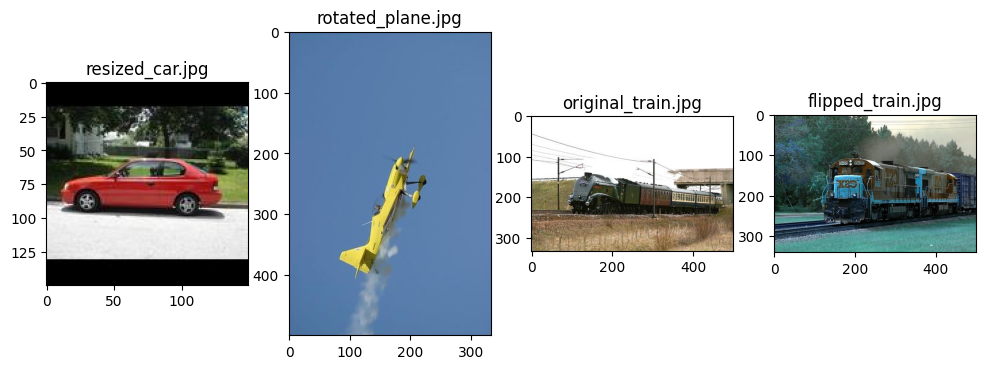

In [25]:
# Set up a figure of an appropriate size
fig = plt.figure(figsize=(12, 12))
file_names = os.listdir(image_folder)
img_num = 0
for file_name in file_names:
    file_path = os.path.join(image_folder, file_name)
    # Open the file using the matplotlib.image library
    image = mp_image.imread(file_path)
    # Add the image to the figure (which will have 1 row, a column for each filename, and a position based on its index in the file_names list)
    a=fig.add_subplot(1, len(file_names), file_names.index(file_name)+1)
    # Add the image to the plot
    image_plot = plt.imshow(image)
    # Add a caption with the file name
    a.set_title(file_name)

# Show the plot
plt.show()

## Acknowledgements and Citations

The data used in this exercise includes images adapted from the PASCAL Visual Object Classes Challenge (VOC2007) dataset at http://host.robots.ox.ac.uk/pascal/VOC/voc2007/.


    @misc{pascal-voc-2007,
        author = "Everingham, M. and Van~Gool, L. and Williams, C. K. I. and Winn, J. and Zisserman, A.",
        title = "The {PASCAL} {V}isual {O}bject {C}lasses {C}hallenge 2007 {(VOC2007)} {R}esults",
        howpublished = "http://www.pascal-network.org/challenges/VOC/voc2007/workshop/index.html"}